# Read Gamma + Muon Simulations and Fit to Lab Data + Smear (vz2)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

**OLD VERSION, USE VZ5 INSTEAD**

### Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import moyal, chisquare

import ROOT
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import matplotlib as mpl
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# import deDisperse_util as util
import matplotlib.colors as colors

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
mpl.style.use('seaborn-colorblind')

from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

%cd /home/dt592/Geant4Work/gamma_sim/gamma_sim-build
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver
ped = 50 #pedestal correction

from langaus import LanGausFit # Import Langaus fit curve for PyROOT.
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02


/tmp/ipykernel_15609/1424964050.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


/vast/palmer/home.grace/dt592/Geant4Work/gamma_sim/gamma_sim-build
/vast/palmer/home.grace/dt592/Geant4Work


### Import Simulated .ROOT Files

In [2]:
folder_g = "/home/dt592/Geant4Work/gamma_sim/gamma_sim-build/" # location of the gamma sim build folder
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder
 
# Open ROOT files
# f1460 = ROOT.TFile.Open(folder_g + "K40J_normalized.root","READ")
# f2614 = ROOT.TFile.Open(folder_g + "Tl208J_normalized.root","READ")
f1460 = ROOT.TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
f2614 = ROOT.TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

# Bismuth peaks
f1120 = ROOT.TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
f1238 = ROOT.TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
f1764 = ROOT.TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
f2204 = ROOT.TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")

# Lower peaks
f968 = ROOT.TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
f934 = ROOT.TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
f911 = ROOT.TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
f609 = ROOT.TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")
f583 = ROOT.TFile.Open(folder_g + "Tl208-583KeV-25x.root", "READ")

# Muons
muons = ROOT.TFile(folder_m + "muonsJ_normalized.root", "READ")

## 

# Read the TTree for main two gamma isotopes
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# Read the TTree for the nearby Bismuth-214 isotopes
tree1120 = f1120.Get("Hits")
tree1238 = f1238.Get("Hits")
tree1764 = f1764.Get("Hits")
tree2204 = f2204.Get("Hits")

# Read the TTree for the remaining low-freq. isotopes
tree968 = f968.Get("Hits")
tree934 = f934.Get("Hits")
tree911 = f911.Get("Hits")
tree609 = f609.Get("Hits")
tree583 = f583.Get("Hits")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

In [3]:
# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)
    
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)
    
## 
    
# Append the Bismuth peaks
energyDeposited1120 = []
entries= tree1120.GetEntries();
for i in range(0,entries):
    tree1120.GetEntry(i)
    energyDeposited1120.append(tree1120.EnergyDeposited)

energyDeposited1238 = []
entries= tree1238.GetEntries();
for i in range(0,entries):
    tree1238.GetEntry(i)
    energyDeposited1238.append(tree1238.EnergyDeposited)

energyDeposited1764 = []
entries= tree1764.GetEntries();
for i in range(0,entries):
    tree1764.GetEntry(i)
    energyDeposited1764.append(tree1764.EnergyDeposited)

energyDeposited2204 = []
entries= tree2204.GetEntries();
for i in range(0,entries):
    tree2204.GetEntry(i)
    energyDeposited2204.append(tree2204.EnergyDeposited)
    
# And the remaining peaks
energyDeposited968 = []
entries= tree968.GetEntries();
for i in range(0,entries):
    tree968.GetEntry(i)
    energyDeposited968.append(tree968.EnergyDeposited)

energyDeposited934 = []
entries= tree934.GetEntries();
for i in range(0,entries):
    tree934.GetEntry(i)
    energyDeposited934.append(tree934.EnergyDeposited)

energyDeposited911 = []
entries= tree911.GetEntries();
for i in range(0,entries):
    tree911.GetEntry(i)
    energyDeposited911.append(tree911.EnergyDeposited)

energyDeposited609 = []
entries= tree609.GetEntries();
for i in range(0,entries):
    tree609.GetEntry(i)
    energyDeposited609.append(tree609.EnergyDeposited)

energyDeposited583 = []
entries= tree583.GetEntries();
for i in range(0,entries):
    tree583.GetEntry(i)
    energyDeposited583.append(tree583.EnergyDeposited)

In [4]:
# Concatenate the energies into np arrays
g_mev = np.concatenate((energyDeposited1460,energyDeposited2614,energyDeposited1120,energyDeposited1238,energyDeposited1764,energyDeposited2204,energyDeposited968,energyDeposited934,energyDeposited911,energyDeposited609,energyDeposited583)) # gamma 
mu_mev = np.array(muonsEnergy) # muons
sim_mev = np.concatenate((g_mev, mu_mev)) # total

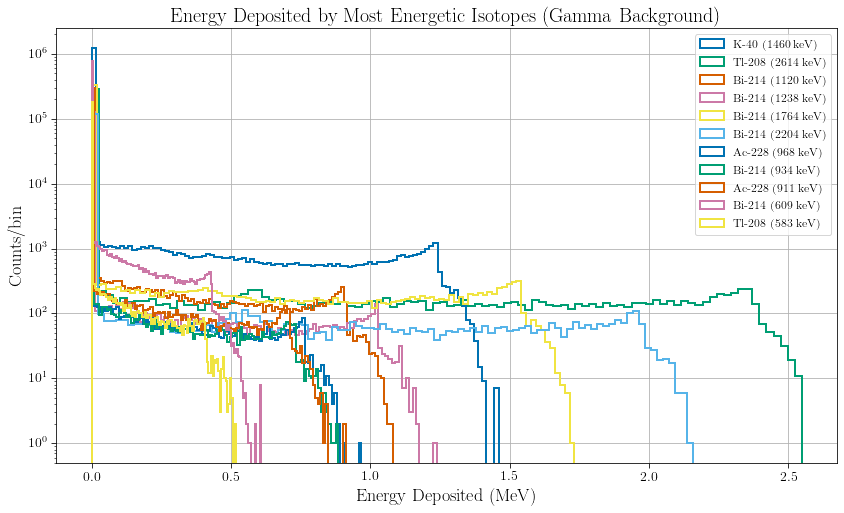

In [5]:
plt.figure(figsize=(14,8))

# Plot the gamma spectra
plt.hist(np.array(energyDeposited1460), bins=100, histtype="step", lw=2, label = "K-40 (1460 keV)")
plt.hist(np.array(energyDeposited2614), bins=100, histtype="step", lw=2, label = "Tl-208 (2614 keV)")
plt.hist(np.array(energyDeposited1120), bins=100, histtype="step", lw=2, label = "Bi-214 (1120 keV)")
plt.hist(np.array(energyDeposited1238), bins=100, histtype="step", lw=2, label = "Bi-214 (1238 keV)")
plt.hist(np.array(energyDeposited1764), bins=100, histtype="step", lw=2, label = "Bi-214 (1764 keV)")
plt.hist(np.array(energyDeposited2204), bins=100, histtype="step", lw=2, label = "Bi-214 (2204 keV)")
plt.hist(np.array(energyDeposited968), bins=100, histtype="step", lw=2, label = "Ac-228 (968 keV)")
plt.hist(np.array(energyDeposited934), bins=100, histtype="step", lw=2, label = "Bi-214 (934 keV)")
plt.hist(np.array(energyDeposited911), bins=100, histtype="step", lw=2, label = "Ac-228 (911 keV)")
plt.hist(np.array(energyDeposited609), bins=100, histtype="step", lw=2, label = "Bi-214 (609 keV)")
plt.hist(np.array(energyDeposited583), bins=100, histtype="step", lw=2, label = "Tl-208 (583 keV)")

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.title("Energy Deposited by Most Energetic Isotopes (Gamma Background)")
# plt.savefig("GammasFluxSim-MoreIsotopes-v2.jpg")
plt.show()

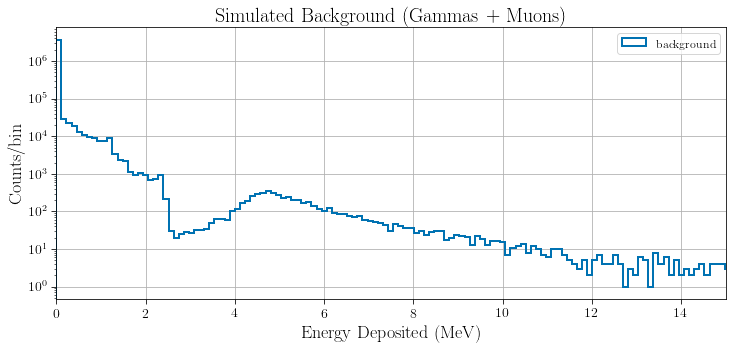

In [6]:
plt.figure(figsize=(12,5))

# Plot the gamma spectra
plt.hist(np.array(sim_mev), bins=300, histtype="step", lw=2, label = "background");

plt.grid()
plt.yscale("log")
plt.xlabel("Energy Deposited (MeV)")
plt.ylabel("Counts/bin")
plt.legend()
plt.xlim(0,15)
plt.title("Simulated Background (Gammas + Muons)")
# plt.savefig("MuonsGammasFluxSimForCUORE.jpg")
plt.show()

### Load and read lab data from directory

In [7]:
sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


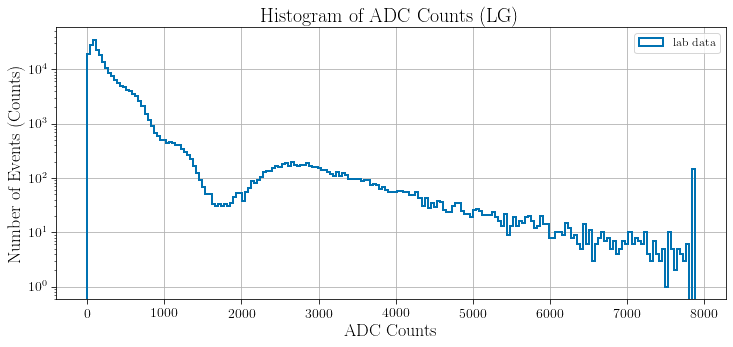

In [8]:
plt.figure(figsize=(12,5))

plt.hist(data['data']['low_gain']-ped, bins=200, lw = 2, label='lab data', histtype='step')

# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('Histogram of ADC Counts (LG)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

In [9]:
# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

In [10]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

<Figure size 864x360 with 0 Axes>

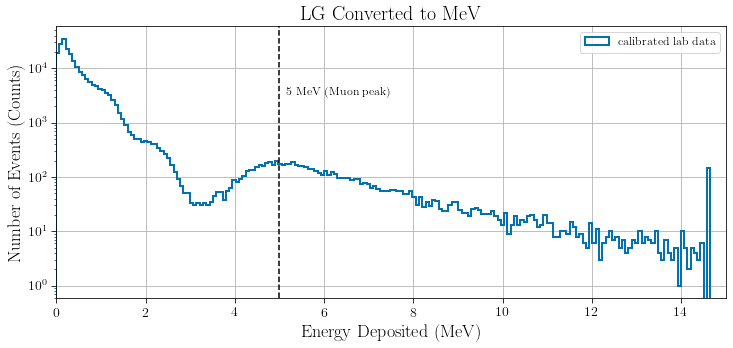

In [11]:
plt.figure(figsize=(12,5))
fig, ax = plt.subplots(figsize=(12,5))

plt.hist(lab_mev, bins=200, histtype='step', lw = 2, label='calibrated lab data')

trans = ax.get_xaxis_transform() # the x coords of this transformation are data, and the y coord are axes
plt.axvline(5, color='k', linestyle='--')
plt.text(5.15,0.75,'5 MeV (Muon peak)',transform=trans)

plt.xlim(0,15)
# plt.ylim(0,1000)
plt.xlabel('Energy Deposited (MeV)')
plt.ylabel('Number of Events (Counts)')
plt.title('LG Converted to MeV')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### Smearing first attempt (Constant sigma)

Using the sigma calculated from the gaussian Cs-137 fit, I applied smearing using the following function as a sort of “first pass.”

Because we are applying smearing in PE but the plot is in MeV, I am converting smearing to PE first when applying it, and then back to MeV for the plot, hence the *pe_mev multiplication.

Here is the first attempt with a “constant” smearing. Of course, smearing is not necessarily constant with energy, so for my second attempt I will try modeling it linearly and see what happens.

In [12]:
sim_pe = sim_mev * pe_mev

<Figure size 864x864 with 0 Axes>

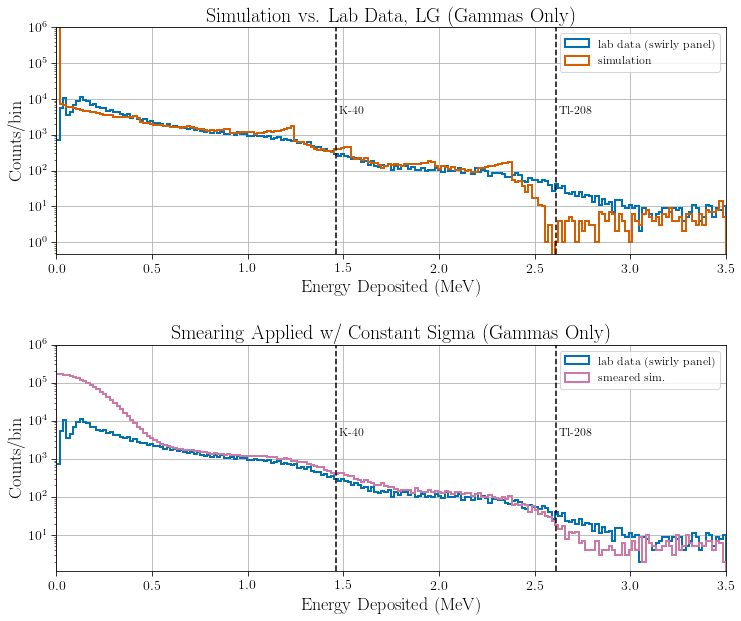

In [13]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

mugam_cut = 3.5 # separation between muon peak and gamma bg
lv = 3.8 * 10**3

#apply smearing
bg_smeared = np.random.normal(loc=sim_mev * pe_mev, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Gammas Only)')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Constant Sigma (Gammas Only)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv2-ConstSmearing-Gammas.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

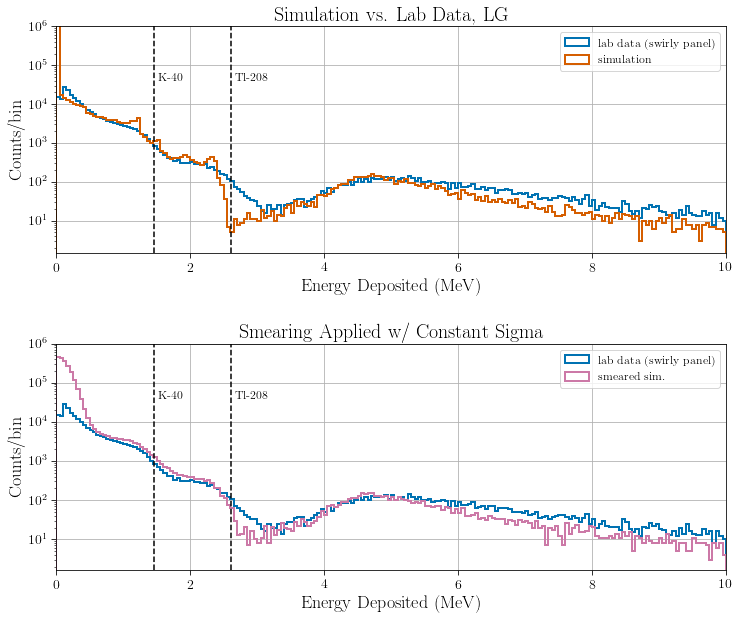

In [14]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(1,1,figsize=(12,10))

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

mugam_cut = 10 # separation between muon peak and gamma bg
lv = 3.8 * 10**4

#apply smearing
bg_smeared = np.random.normal(loc=sim_mev * pe_mev, scale = sigma_pe)

# Plot 1: Gamma simulation + lab data, gamma smearing + lab data
# plt.figure(1)

plt.subplot(211)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)');
plt.xlim(0, mugam_cut)
# plt.ylim(0, 10**6)
plt.ylabel('Counts/bin');
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG')

# plt.savefig("LabDataVsActualMuons.jpg")

plt.subplot(212)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Constant Sigma')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv2-ConstSmearing-FullSpectrum.jpg")

plt.show()

### Smearing second attempt (linear sigma)

<Figure size 864x864 with 0 Axes>

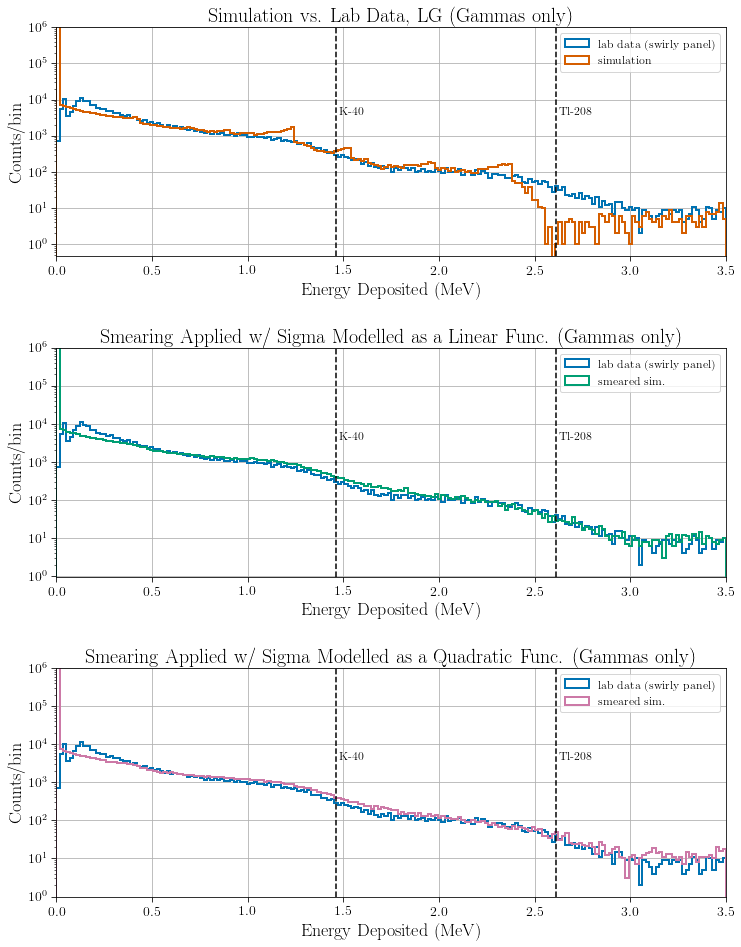

In [15]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,1,figsize=(12,16))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

mugam_cut = 3.5 # separation between muon peak and gamma bg
lv = 3.8 * 10**3 

#apply smearing
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe)
bg_smeared_qua = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe + 0.00001 * lin_sigma_pe * np.power(sim_pe, 2))


# Plot 2: Gamma simulation + lab data, linear smearing + lab data, quadratic smearing + lab data
plt.subplot(311)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG (Gammas only)')

#

plt.subplot(312)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Linear Func. (Gammas only)')

#

plt.subplot(313)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_qua/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.48,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.63,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Quadratic Func. (Gammas only)')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv2-LinSmearing-Gammas.jpg")

plt.show()

<Figure size 864x864 with 0 Axes>

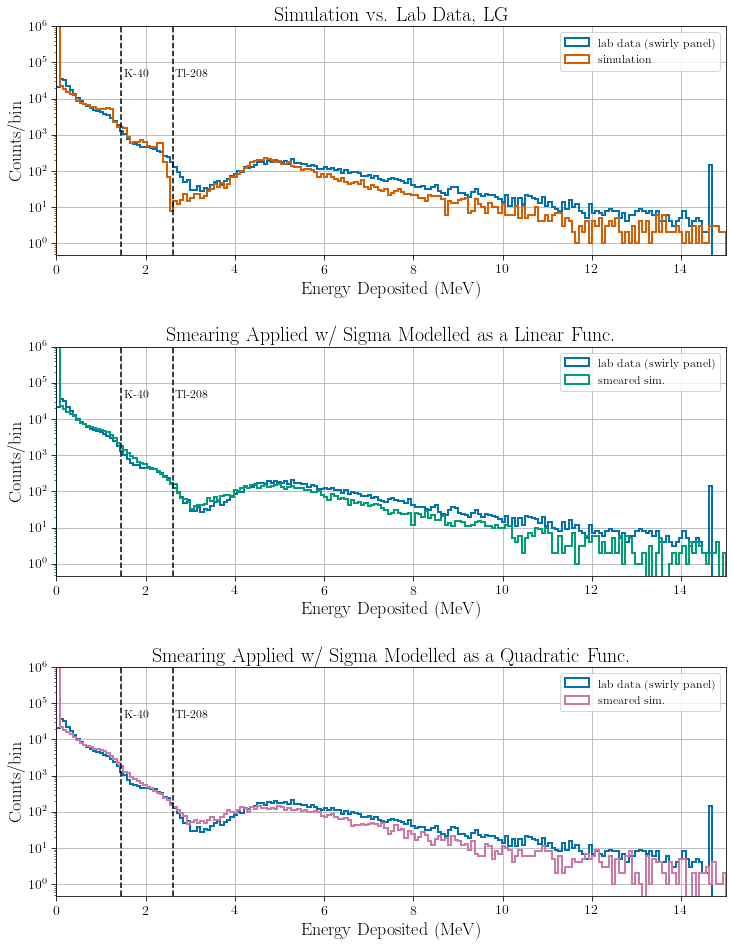

In [16]:
plt.figure(figsize=(12,12))
fig, axs = plt.subplots(2,1,figsize=(12,16))

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

mugam_cut = 15 # separation between muon peak and gamma bg
lv = 3.8 * 10**4

#apply smearing
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe)
bg_smeared_qua = np.random.normal(loc=sim_pe, scale = 0.01 * lin_sigma_pe * sim_pe + 0.00001 * lin_sigma_pe * np.power(sim_pe, 2))


# Plot 2: Gamma simulation + lab data, linear smearing + lab data, quadratic smearing + lab data
plt.subplot(311)

plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(sim_mev, bins=200, range=(0, mugam_cut), histtype='step', label='simulation', lw=2) #simulation

#label isotope peaks
plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.legend(loc=1)
plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Simulation vs. Lab Data, LG')

#

plt.subplot(312)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist(bg_smeared_lin/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Linear Func.')

#

plt.subplot(313)
plt.hist(lab_mev, bins=200, range=(0, mugam_cut), histtype='step', label='lab data (swirly panel)', lw=2) #lab data
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist([], bins=1, range=(0, 0), histtype='step', lw=2) #Plot empty hists to change color
plt.hist(bg_smeared_qua/pe_mev, bins=200, range=(0, mugam_cut), histtype='step', label='smeared sim.', lw=2) #smeared

plt.legend(loc=1)

plt.axvline(1.460, color='k', linestyle='--')
plt.text(1.52,lv,'K-40')
plt.axvline(2.614, color='k', linestyle='--')
plt.text(2.67,lv,'Tl-208')

plt.grid()
plt.xlabel('Energy Deposited (MeV)')
plt.xlim(0, mugam_cut)
plt.ylabel('Counts/bin')
plt.yscale("log")
plt.ylim(0, 10**6)
plt.title('Smearing Applied w/ Sigma Modelled as a Quadratic Func.')

plt.subplots_adjust(hspace=0.4)

# plt.savefig("NBv2-LinSmearing-MoreSpectrum.jpg")

plt.show()

### Use PyROOT to get Chi2 value for the smearing

4.0975547334133156

Chi2 = 815.413392, Prob = 1.59409e-75, NDF = 199, igood = 0


Warning in <TFile::Append>: Replacing existing TH1: lab (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


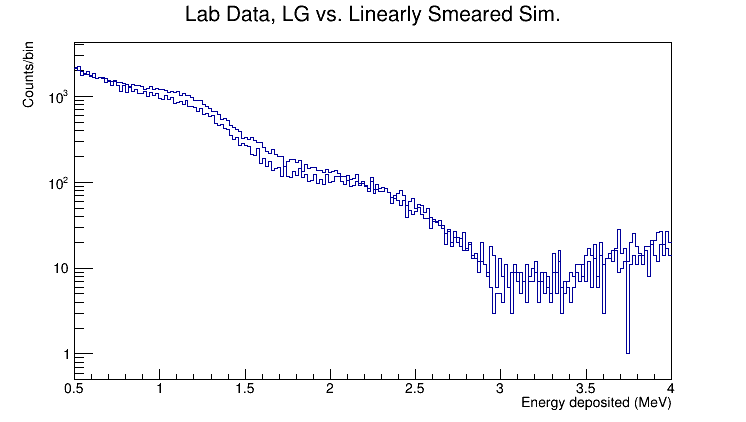

In [53]:
#Try this
bg_smeared_lin = np.random.normal(loc=sim_pe, scale = 0.009315 * lin_sigma_pe * sim_pe)

# Turn smeared and lab data into ROOT Histograms
lab_th = ROOT.TH1D('lab', 'Lab Data, LG vs. Linearly Smeared Sim.', 200, 0.5, 4)
fill_hist(lab_th, lab_mev)

smeared_lin_th = ROOT.TH1D('smeared', 'Smeared Simulation (Linear)', 200, 0.5, 4)
fill_hist(smeared_lin_th, bg_smeared_lin/pe_mev)

c1 = ROOT.TCanvas('c1','c1', 200, 10, 750, 450)

lab_th.Draw()
lab_th.GetXaxis().SetTitle("Energy deposited (MeV)")
lab_th.GetYaxis().SetTitle("Counts/bin")

smeared_lin_th.Draw("same")
smeared_lin_th.GetXaxis().SetTitle("Energy deposited (MeV)")
smeared_lin_th.GetYaxis().SetTitle("Counts/bin")

ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptStat(0)
# ROOT.gPad.SetGrid()

c1.Draw()

smeared_lin_th.Chi2Test(lab_th, "P")
smeared_lin_th.Chi2Test(lab_th, "CHI2/NDF")

##### 

In [41]:
chi2 = []
coeff = []

for i in range(9000,10000):
    bg_smeared_lin = np.random.normal(loc=sim_pe, scale = i * 0.000001 * lin_sigma_pe * sim_pe)
    smeared_lin_th = ROOT.TH1D('smeared', 'Smeared Simulation (Linear)', 200, 0.5, 4)
    fill_hist(smeared_lin_th, bg_smeared_lin/pe_mev)
    
    print(i - 8999, i * 0.000001, smeared_lin_th.Chi2Test(lab_th, "CHI2/NDF"))
    chi2.append(smeared_lin_th.Chi2Test(lab_th, "CHI2/NDF"))
    coeff.append(i * 0.000001)

1 0.009 4.297378423381469
2 0.009001 4.097656496901087
3 0.009002 4.241935922146894
4 0.009002999999999999 4.355012121312812
5 0.009004 4.315924304296245
6 0.009004999999999999 4.248554102226937
7 0.009006 4.187176866129112
8 0.009007 4.300309559323414
9 0.009008 4.094266805259748
10 0.009009 4.157285488130751
11 0.009009999999999999 4.437934985088613
12 0.009011 4.383096889037988
13 0.009012 4.2932250581506315
14 0.009013 4.23045573534519
15 0.009014 4.1921951432712765
16 0.009015 4.063643836933153
17 0.009016 4.464601541977067
18 0.009016999999999999 4.687742937211525
19 0.009018 4.144501563916766
20 0.009019 4.132273042783935
21 0.00902 4.27025132419864
22 0.009021 4.130317051962627
23 0.009021999999999999 3.876796352415086
24 0.009023 4.411498141983374
25 0.009023999999999999 4.401893718080014
26 0.009025 4.32496365583709
27 0.009026 4.377731494873719
28 0.009027 4.586809674883632
29 0.009028 4.407999678655509
30 0.009028999999999999 4.205373426407544
31 0.00903 4.210572711545355
3

247 0.009245999999999999 4.239660543654687
248 0.009247 4.291811398608892
249 0.009248 4.177854811090824
250 0.009249 4.377373409203907
251 0.00925 4.2723921028460685
252 0.009250999999999999 4.297727375109563
253 0.009252 4.215511525327955
254 0.009252999999999999 4.154928574930089
255 0.009254 4.195082468485187
256 0.009255 4.32668992606631
257 0.009256 4.334430678876093
258 0.009257 4.413936159803633
259 0.009257999999999999 4.187156900180707
260 0.009259 4.337031057840651
261 0.00926 4.093174494748479
262 0.009261 4.1361737394181395
263 0.009262 4.30939678579261
264 0.009263 4.373871267890657
265 0.009264 4.6557041309673854
266 0.009264999999999999 4.299922217459628
267 0.009266 4.409773488673332
268 0.009267 4.2166932042958285
269 0.009268 4.373373810774945
270 0.009269 4.105551442377269
271 0.009269999999999999 4.192652022261678
272 0.009271 4.130200111340066
273 0.009271999999999999 4.1414515143286295
274 0.009273 4.144339601621326
275 0.009274 4.167272415778653
276 0.009275 4.3

489 0.009488 4.034440780842766
490 0.009489 4.296013884903813
491 0.00949 4.224034731485239
492 0.009491 4.203048310516877
493 0.009492 4.315168663498808
494 0.009493 4.154468735137578
495 0.009493999999999999 4.368860639402795
496 0.009495 4.2272897219079955
497 0.009496 4.482582592545758
498 0.009497 4.20966073174541
499 0.009498 4.298889528338611
500 0.009498999999999999 4.342865574332376
501 0.0095 4.431848720431961
502 0.009500999999999999 4.200636621764856
503 0.009502 4.197172958833194
504 0.009503 4.245250926468681
505 0.009504 4.303245437764871
506 0.009505 4.143036168349572
507 0.009505999999999999 4.349912481024668
508 0.009507 4.028806376636596
509 0.009507999999999999 4.349331572950258
510 0.009509 4.151591689398231
511 0.00951 4.336251097630473
512 0.009511 4.180507998828372
513 0.009512 4.093877278410599
514 0.009512999999999999 4.169395675655809
515 0.009514 4.247679307212215
516 0.009515 4.123163575398239
517 0.009516 4.300250865475148
518 0.009517 4.358761261329624
51

731 0.009729999999999999 4.277101525246938
732 0.009731 4.302532831199495
733 0.009732 4.142704171263353
734 0.009733 4.287607773092403
735 0.009734 4.327990611582736
736 0.009734999999999999 4.0251308694025365
737 0.009736 4.330304339721902
738 0.009736999999999999 4.341281186210571
739 0.009738 4.420628440547687
740 0.009739 4.238385585812234
741 0.00974 4.233209212505089
742 0.009741 4.188659695194619
743 0.009741999999999999 4.2815991334167345
744 0.009743 4.3526975607562255
745 0.009744 4.329136684396767
746 0.009745 4.100933778970572
747 0.009746 4.308298624113176
748 0.009746999999999999 4.186498029703699
749 0.009748 4.191966831661826
750 0.009748999999999999 4.174597021860474
751 0.00975 4.196028000386534
752 0.009751 4.352112654547294
753 0.009752 4.039169555593027
754 0.009753 4.067386951752595
755 0.009753999999999999 4.150756501096683
756 0.009755 4.182835004530777
757 0.009755999999999999 4.19055166435857
758 0.009757 3.8486167682095607
759 0.009758 4.190560377010422
760 

972 0.009970999999999999 4.2327421250610975
973 0.009972 4.291476717008413
974 0.009973 4.083500736449835
975 0.009974 4.064311943836919
976 0.009975 4.086556555624803
977 0.009975999999999999 4.336783955437955
978 0.009977 4.01548617338157
979 0.009977999999999999 4.633388102616882
980 0.009979 4.049206065372486
981 0.00998 4.325697458911623
982 0.009981 4.124011795018438
983 0.009982 4.488392381473362
984 0.009982999999999999 4.4313678612452
985 0.009984 4.264680879805117
986 0.009984999999999999 4.221244541702658
987 0.009986 4.082161863717087
988 0.009987 4.293242201927037
989 0.009988 4.185794122813001
990 0.009989 4.326107061544078
991 0.009989999999999999 4.014162583002675
992 0.009991 3.995245262458449
993 0.009992 4.306006199813266
994 0.009993 4.012254237224368
995 0.009994 4.056983821557147
996 0.009995 4.343108928475581
997 0.009996 4.214791021282779
998 0.009996999999999999 4.33912380462832
999 0.009998 4.358040943605112
1000 0.009999 4.052339011277185


Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: smeared (Pote

In [42]:
chi2

[4.297378423381469,
 4.097656496901087,
 4.241935922146894,
 4.355012121312812,
 4.315924304296245,
 4.248554102226937,
 4.187176866129112,
 4.300309559323414,
 4.094266805259748,
 4.157285488130751,
 4.437934985088613,
 4.383096889037988,
 4.2932250581506315,
 4.23045573534519,
 4.1921951432712765,
 4.063643836933153,
 4.464601541977067,
 4.687742937211525,
 4.144501563916766,
 4.132273042783935,
 4.27025132419864,
 4.130317051962627,
 3.876796352415086,
 4.411498141983374,
 4.401893718080014,
 4.32496365583709,
 4.377731494873719,
 4.586809674883632,
 4.407999678655509,
 4.205373426407544,
 4.210572711545355,
 4.107959383469547,
 4.27677509599661,
 4.3815987442999775,
 4.130279430433319,
 4.234759053109358,
 4.350040304224541,
 4.159086637184968,
 4.066429559457215,
 4.277600644923602,
 4.523657795287936,
 4.175119102375033,
 4.362366316550757,
 4.463595108763442,
 4.167607815184689,
 4.059634867133415,
 4.125304411520877,
 4.370609886795729,
 4.256040115657114,
 4.210771351367217,
 

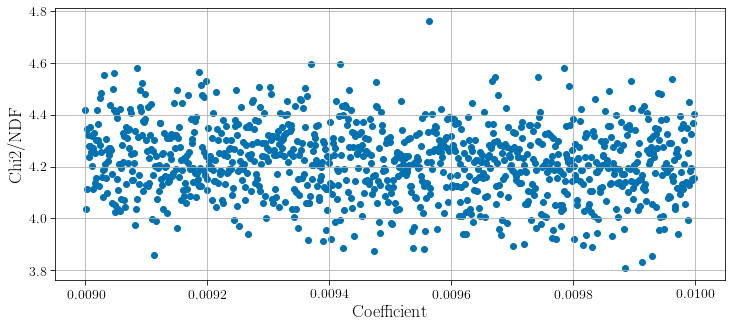

In [32]:
plt.figure(figsize=(12,5))

plt.scatter(coeff, chi2)

# plt.xlim(0,15)
# plt.ylim(0,1000)
plt.xlabel('Coefficient')
plt.ylabel('Chi2/NDF')
# plt.title('pls')
# plt.yscale('log')
# plt.legend()
plt.grid()
# plt.savefig("NBv2-CoeffvsChi2.jpg")
plt.show()

In [43]:
min(chi2)

3.84717511157406

In [45]:
chi2.index(3.84717511157406)

346

In [46]:
coeff[346]

0.009346